### 这篇是用 paddlepaddle 写房价预测





In [1]:

#加载飞桨、Numpy和相关类库

import matplotlib.pyplot as plt
import numpy as np
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import FC

# 数据加载工具类
from util.housing_util import load_data, load_one_example

# 加载数据后的统计值变量，在 load_data 后设置，为最大，最小，平均。用于计算归一化值
global all_stastic





### 1.数据预处理 ，直接加载之前的工具类housing_util.py，一致的
### 2.模型设计

这里设计双层网络。一层输入层，一层隐层




In [2]:

class Regressor(fluid.dygraph.Layer):
    
    def __init__(self, name_scope) :
        super(Regressor,self).__init__(name_scope)
        name_scope = self.full_name()
        
        # 定义全连接层，这里没加 bias。和设计的算法有点出入，后面看下API 说明加上
        self.fc1 = FC(name_scope, size=13, act=None)
        self.fc2 = FC(name_scope, size=1, act=None)
        
        
    # 网络前向计算函数
    def forward(self, inputs):
        a_h = self.fc1(inputs)
        y = self.fc2(a_h)
        
        return y
    
    

        
  
 

### 3.训练配置



In [3]:
with fluid.dygraph.guard():
    model = Regressor("Regressor")
    
    # 开启模型训练模式
    model.train()
    
    
    # 加载数据
    training_data, test_data , my_all_stastic = load_data()
    
    all_stastic = my_all_stastic
    print(all_stastic)
    # 学习率设置为 0.01
    opt = fluid.optimizer.SGD(learning_rate=0.01)





[array([ 88.9762, 100.    ,  25.65  ,   1.    ,   0.871 ,   8.78  ,
       100.    ,  12.1265,  24.    , 666.    ,  22.    , 396.9   ,
        37.97  ,  50.    ]), array([6.3200e-03, 0.0000e+00, 4.6000e-01, 0.0000e+00, 3.8500e-01,
       3.5610e+00, 2.9000e+00, 1.1296e+00, 1.0000e+00, 1.8700e+02,
       1.2600e+01, 7.0800e+01, 1.7300e+00, 5.0000e+00]), array([1.91589931e+00, 1.42326733e+01, 9.50232673e+00, 8.66336634e-02,
       5.31731931e-01, 6.33310891e+00, 6.44274752e+01, 4.17421361e+00,
       6.78960396e+00, 3.52910891e+02, 1.80262376e+01, 3.79971757e+02,
       1.13549505e+01, 2.41757426e+01])]



### 4.训练并保存模型

这里用的 mini-batch 方式直接copy 过来的




以参数 epoch: 500, batch_size: 404 训练完成.模型保存成功，模型参数保存在LR_model中


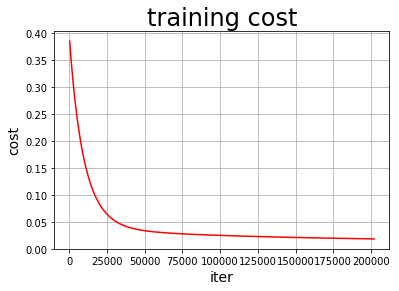

In [4]:

# 这里定义一个训练过程绘图的函数
iter=0
iters=[]
train_costs=[]

def draw_train_process(iters_param, train_costs_param):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters_param, train_costs_param,color='red',label='training cost') 
    plt.grid()
    plt.show()
    
    
# 开始训练
with dygraph.guard():
    EPOCH_NUM = 500   # 设置外层循环次数
    BATCH_SIZE = 404  # 设置batch大小
    
    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含BATCH_SIZE条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]).astype('float32') # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]).astype('float32') # 获得当前批次训练标签（真实房价）
            # 将numpy数据转为飞桨动态图variable形式
            house_features = dygraph.to_variable(x)
            prices = dygraph.to_variable(y)
            
            # print(house_features)
            # 前向计算
            
            predicts = model(house_features)
            
            # 计算损失
            loss = fluid.layers.square_error_cost(predicts, label=prices)
            avg_loss = fluid.layers.mean(loss)
            # if iter_id%20==0:
            #     print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
            
            
            iter=iter+BATCH_SIZE
            iters.append(iter)
            train_costs.append(avg_loss.numpy()[0])
            
            
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()
            
    # 保存模型
    fluid.save_dygraph(model.state_dict(), 'LR_model')
    print("以参数 epoch: {0}, batch_size: {1} 训练完成.模型保存成功，模型参数保存在LR_model中".format(EPOCH_NUM,BATCH_SIZE))
    
draw_train_process(iters,train_costs)
    

### 5. 测试模型，对所有结果进行预测并画出图



In [5]:
with dygraph.guard():
    model_dict, _ = fluid.load_dygraph("LR_model")
    model.load_dict(model_dict)
    # 设置到预测状态
    model.eval()
    for j in range(0,len(test_data)):
        current_test_data, label = load_one_example(j,test_data)
        current_test_data = dygraph.to_variable(current_test_data)
        results = model(current_test_data)
        max_values = all_stastic[0]
        min_values = all_stastic[1]
        avg_values = all_stastic[2]
        
        results = results * (max_values[-1] - min_values[-1]) + avg_values[-1]
        label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]
        
        
        print("预测结果 is {}, 标签结果 is {}".format(results.numpy(), label))



预测结果 is [[8.218459]], 标签结果 is 8.5
预测结果 is [[4.348097]], 标签结果 is 5.0
预测结果 is [[7.1167984]], 标签结果 is 11.9
预测结果 is [[13.962613]], 标签结果 is 27.9
预测结果 is [[15.29248]], 标签结果 is 17.2
预测结果 is [[14.033442]], 标签结果 is 27.5
预测结果 is [[-5.885618]], 标签结果 is 15.0
预测结果 is [[7.688452]], 标签结果 is 17.2
预测结果 is [[-2.6644363]], 标签结果 is 17.9
预测结果 is [[4.192547]], 标签结果 is 16.3
预测结果 is [[-7.4674816]], 标签结果 is 7.0
预测结果 is [[4.7654343]], 标签结果 is 7.199999999999999
预测结果 is [[8.325978]], 标签结果 is 7.5
预测结果 is [[2.5437279]], 标签结果 is 10.4
预测结果 is [[-9.898819]], 标签结果 is 8.8
预测结果 is [[10.014078]], 标签结果 is 8.4
预测结果 is [[16.4884]], 标签结果 is 16.7
预测结果 is [[15.870679]], 标签结果 is 14.2
预测结果 is [[13.410357]], 标签结果 is 20.8
预测结果 is [[5.9772034]], 标签结果 is 13.4
预测结果 is [[4.269991]], 标签结果 is 11.7
预测结果 is [[2.1209755]], 标签结果 is 8.300000000000002
预测结果 is [[6.442566]], 标签结果 is 10.2
预测结果 is [[0.34069252]], 标签结果 is 10.9
预测结果 is [[9.913607]], 标签结果 is 11.0
预测结果 is [[7.7203484]], 标签结果 is 9.5
预测结果 is [[9.889351]], 标签结果 is 14.5
预测结果 is [[11.15306

### 如何评价测试结果呢？




